# Models using libraries

In [19]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os 
import random
import joblib
import torch

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor

# importing custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.load_data import load_data
from scipy.stats import randint, uniform

from src.models.MLP_torch import MLP, train_model
from src.utils.tuning import run_random_search
from src.utils.evaluation import eval_regressor_model, logclaim_to_claimrate
from src.visualization.model_plots import plot_epoch_rmse, tail_residuals_plot, prediction_distribution, prediction_distribution_violin, parity_plot, residual_plot,  plot_learning_curve




In [2]:
target = "log_ClaimRate"

(X_train, y_train_log), (X_test, y_test_log)= load_data(raw=False, target=target)

## Decision tree from sklearn

We make the instance for the DT.

In [3]:
DT = DecisionTreeRegressor(random_state=42)
name = "Decision Tree Regressor from sklearn"

we also need to define our parameter distributions for RandomizedGridSearchCV.

In [4]:

param_dist_DT = {
    "max_depth": randint(10, 50),           # allow deeper trees
    "min_samples_split": randint(2, 20),    # slightly larger range to allow splitting
    "min_samples_leaf": randint(1, 10),     # smaller leaves to capture rare claims
    "max_features": ["sqrt", "log2", None], # keep as is
    "max_leaf_nodes": randint(50, 500),     # allow more leaves
    "ccp_alpha": uniform(0.0, 0.001)        # smaller pruning to prevent underfitting
}



### Training

And we run the hyperparameter tuning model using Randomized Search, and RMSE as the evaluation metric for 25 iterations.

In [5]:
if not os.path.exists("../models/best_DT_sklearn_model.joblib"):
    search = run_random_search(DT, param_dist_DT, X_train, y_train_log, n_iter=50, n_jobs=-1)

Now we have the best model.

In [6]:
# if a best model is already saved, load it
if os.path.exists("../models/best_DT_sklearn_model.joblib"):
    best_model_DT = joblib.load("../models/best_DT_sklearn_model.joblib")
else:
    best_model_DT = search.best_estimator_

In [7]:
best_model_DT.get_params()

{'ccp_alpha': np.float64(1.5966252220214196e-05),
 'criterion': 'squared_error',
 'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': 493,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 13,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [8]:
leaves = best_model_DT.get_n_leaves()
depth = best_model_DT.get_depth()
print(f"Best Decision Tree Model - Leaves: {leaves}, Depth: {depth}")

Best Decision Tree Model - Leaves: 24, Depth: 9


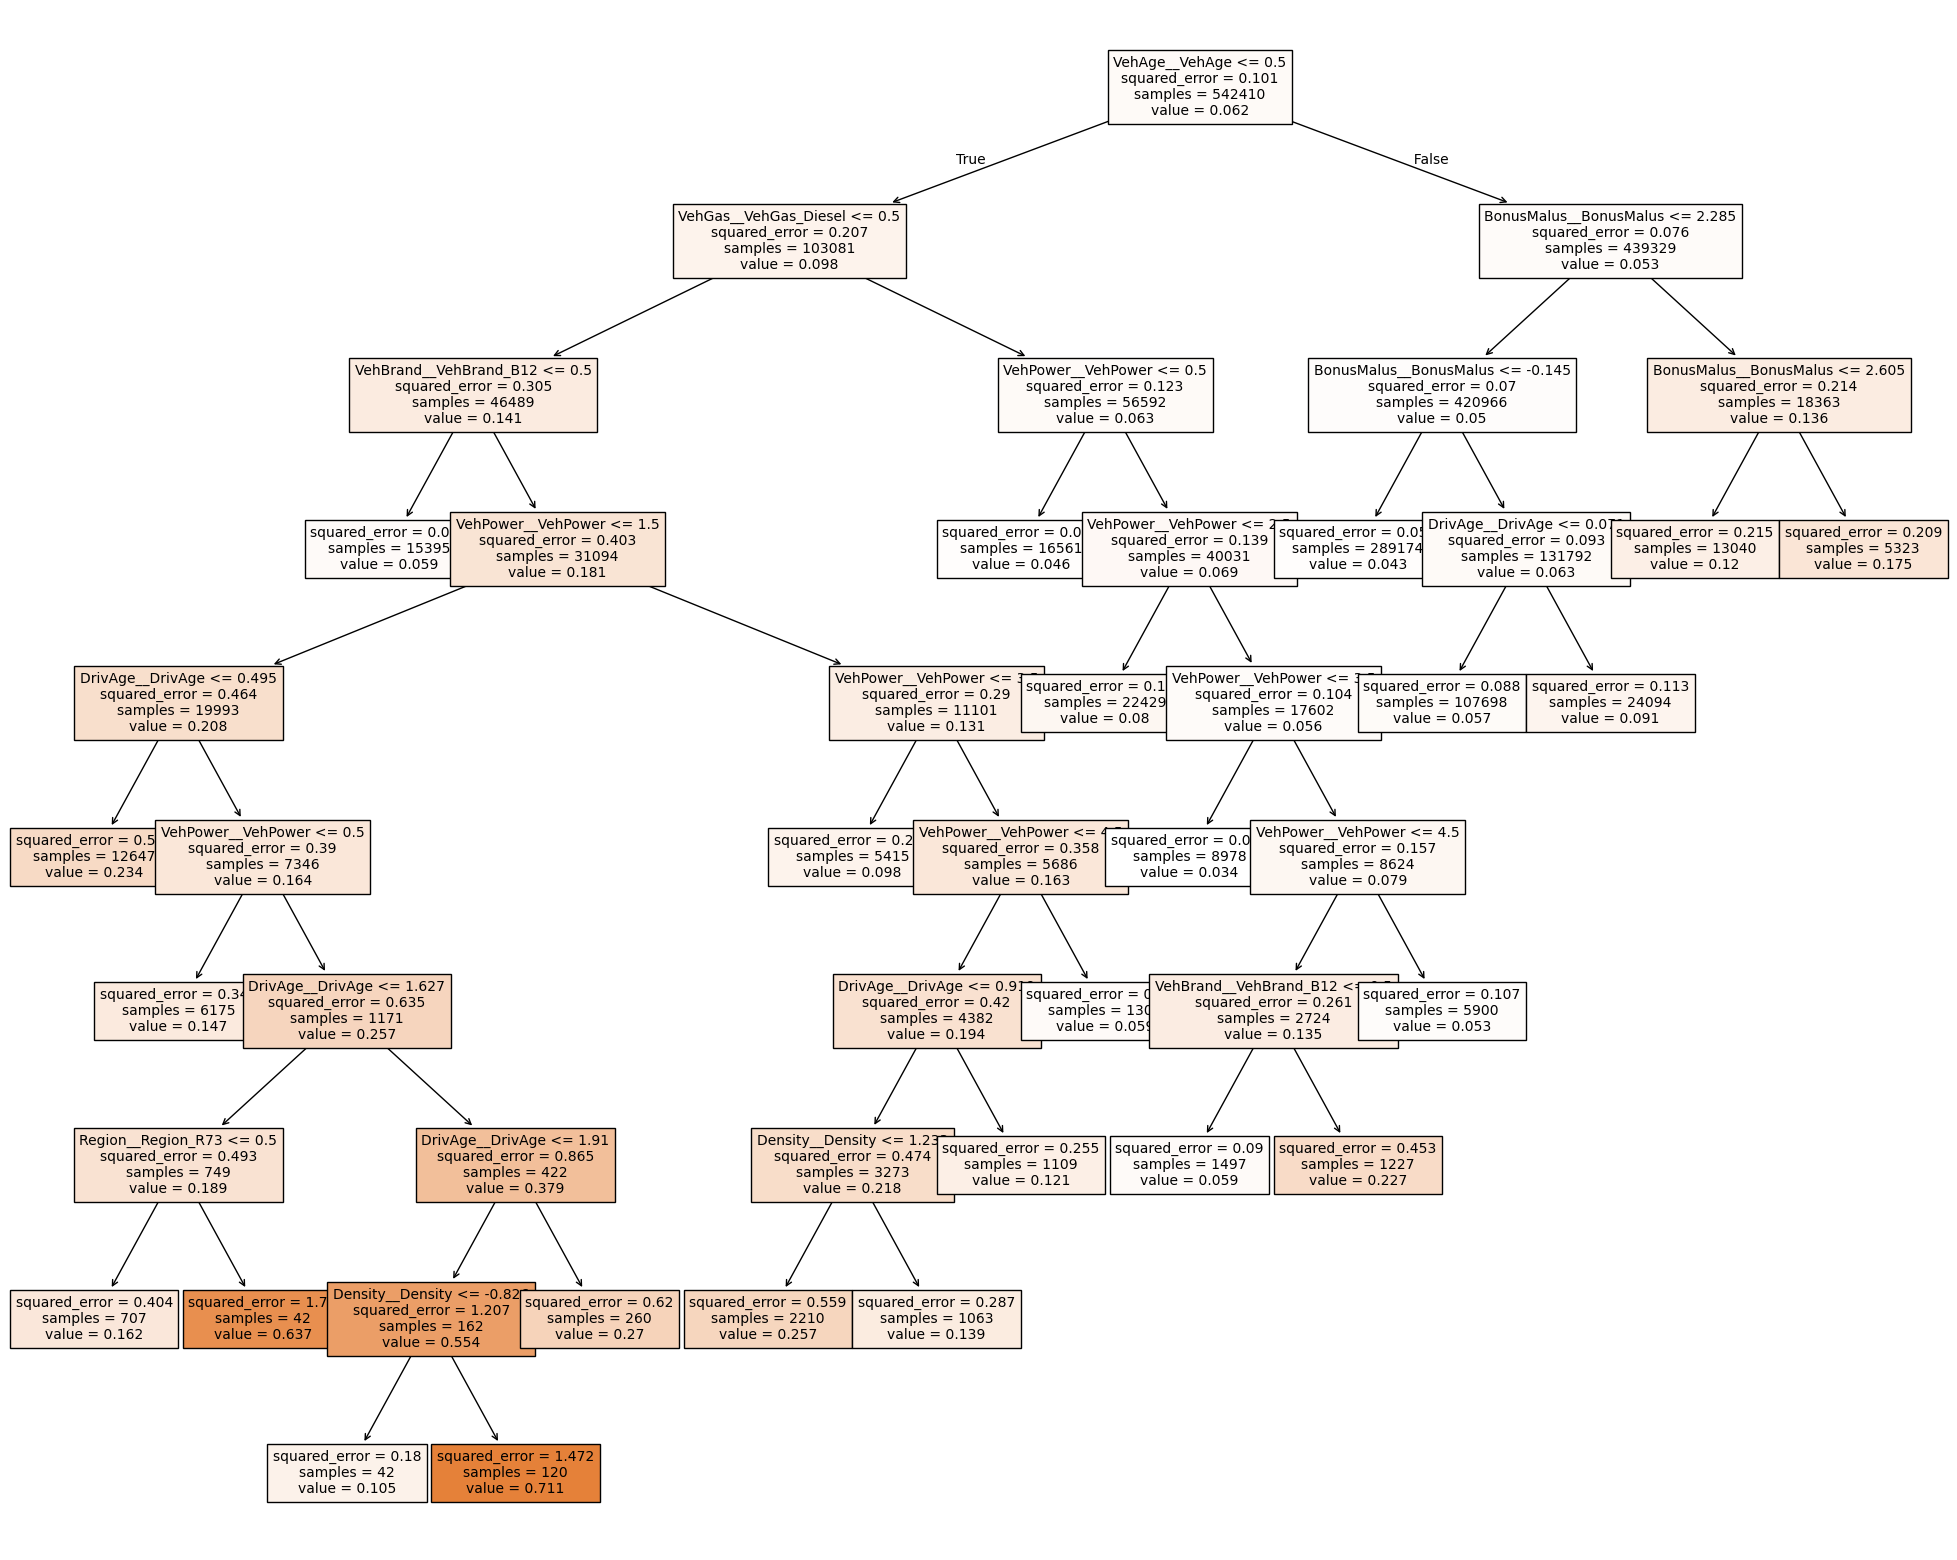

In [9]:
from sklearn import tree

preprocesser = joblib.load("../models/preprocesser_log_ClaimRate.joblib")
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(best_model_DT, filled=True, fontsize=10, feature_names=preprocesser.get_feature_names_out())


### Evaluation

Let's see how it did:

In [50]:
metrics_train_log, y_train_pred_log = eval_regressor_model(best_model_DT, X_train, y_train_log)
metrics_train_log

NameError: name 'best_model_DT' is not defined

In [11]:
y_train_pred_log

array([0.05699581, 0.09079904, 0.05699581, ..., 0.05699581, 0.05699581,
       0.17500684])

Let's change our y values from the log world to claimrate.

In [12]:
y_train = logclaim_to_claimrate(y_train_log)
y_train_pred = logclaim_to_claimrate(y_train_pred_log)

In [13]:
max(y_train)

np.float64(299.9999999999999)

In [14]:
metrics_train = eval_regressor_model(model=None, X=None, y=y_train, y_pred=y_train_pred, log_given=False)
metrics_train

({'MAE': 0.29138727590257063,
  'RMSE': 2.9124267039066574,
  'PoissonDeviance': 2.0416837007577637},
 array([0.05865137, 0.09504892, 0.05865137, ..., 0.05865137, 0.05865137,
        0.19125437]))

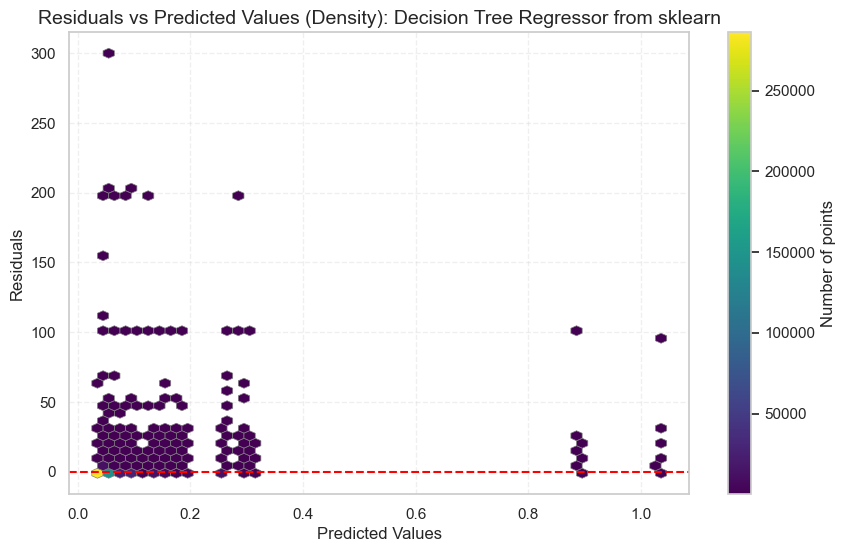

In [15]:
residual_plot(y_true=y_train, y_pred=y_train_pred, name=name)

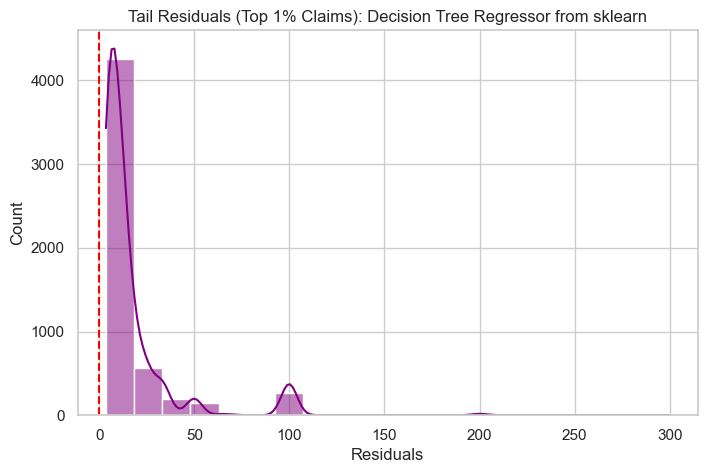

In [16]:
tail_residuals_plot(y_train, y_train_pred, name=name)

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


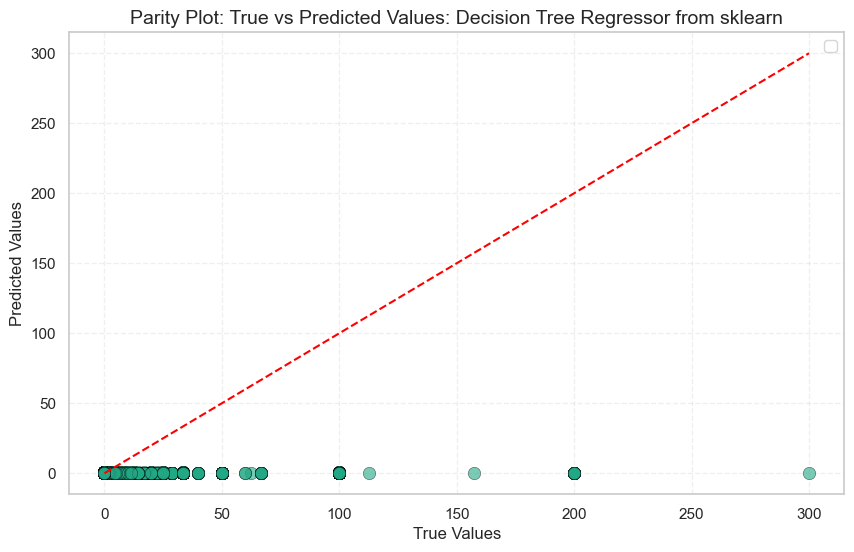

In [17]:
parity_plot(y_true=y_train, y_pred=y_train_pred, name=name)

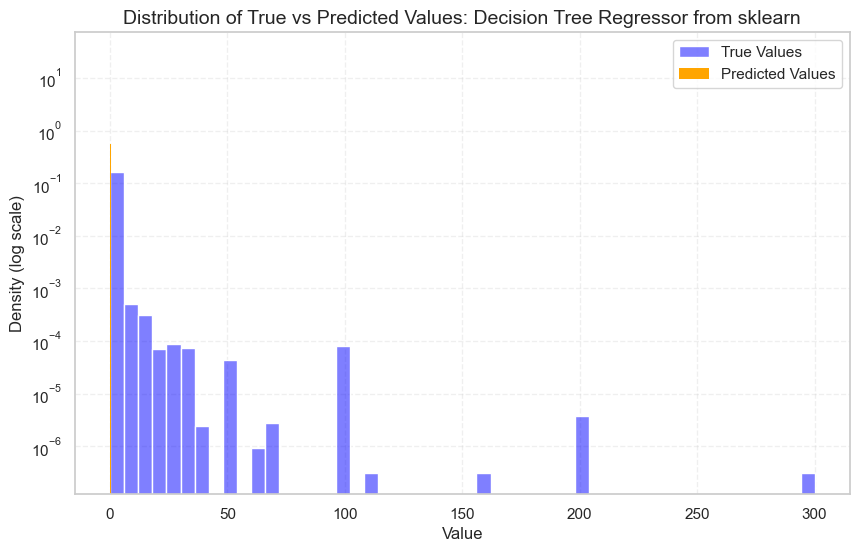

In [18]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred, name=name)

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


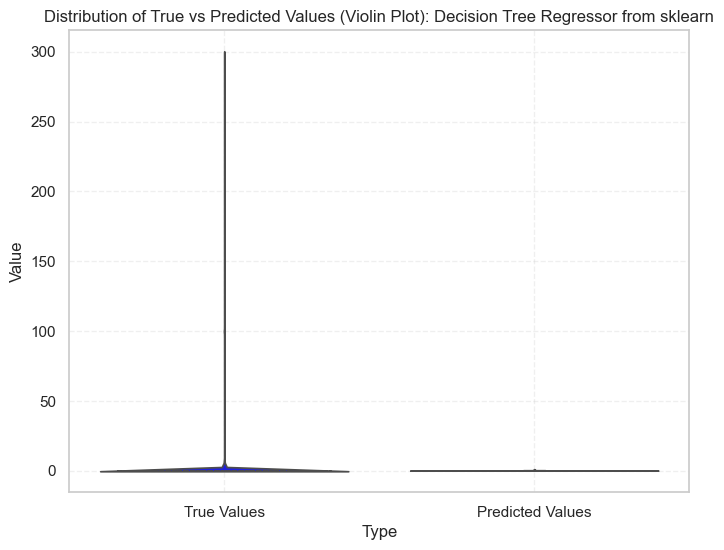

In [19]:
prediction_distribution_violin(y_true=y_train, y_pred=y_train_pred, name=name)

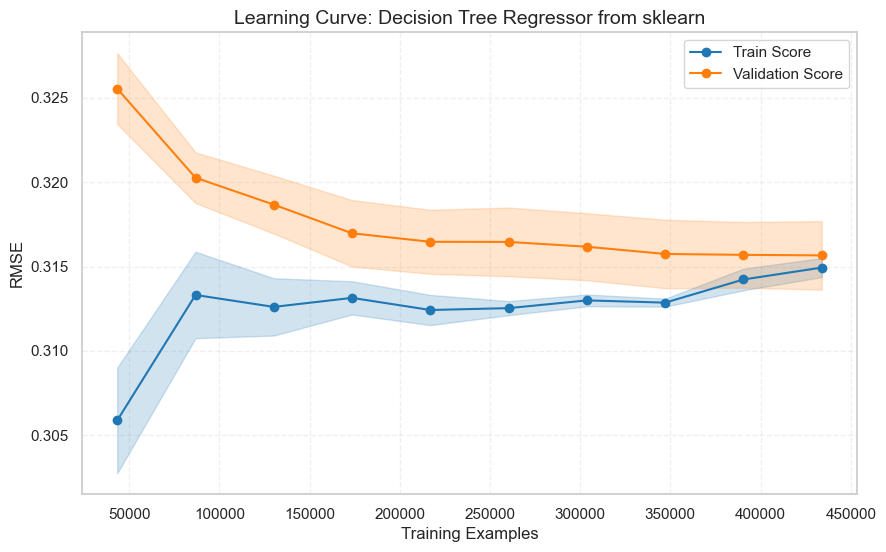

In [20]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model=best_model_DT, X=X_train, y=y_train_log, cv=cv, scoring="neg_root_mean_squared_error", name=name)

### Evaluation on testing set

Let's use our model on the test data.

In [22]:
y_test_pred_log = best_model_DT.predict(X_test)

In [23]:
y_test_pred = logclaim_to_claimrate(y_test_pred_log)
y_test = logclaim_to_claimrate(y_test_log)

In [24]:
eval_regressor_model(model=None, X=None, y=y_test, y_pred=y_test_pred, log_given=False)


({'MAE': 0.29711975250895495,
  'RMSE': 3.0349186578791802,
  'PoissonDeviance': 2.1137945275146324},
 array([0.04431456, 0.05865137, 0.26385978, ..., 0.04431456, 0.060591  ,
        0.04431456]))

similar results.

Let's run the same plots.

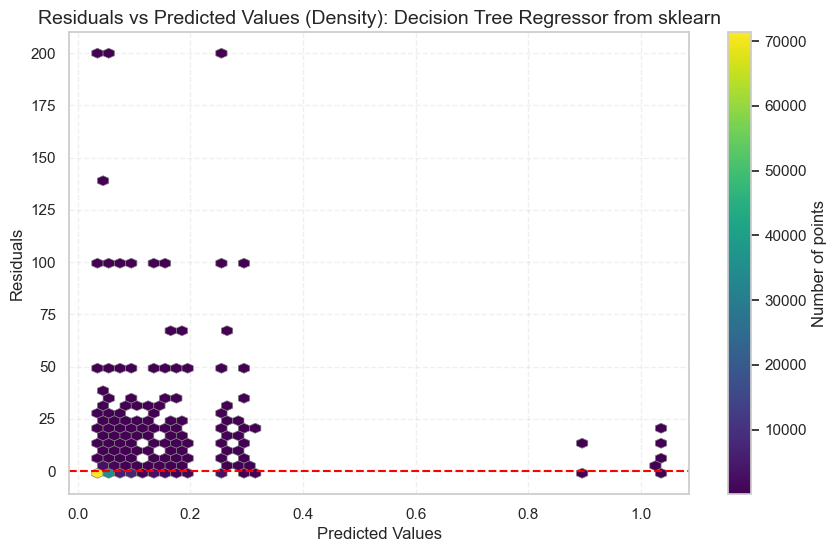

In [25]:
residual_plot(y_true=y_test, y_pred=y_test_pred, name=name)

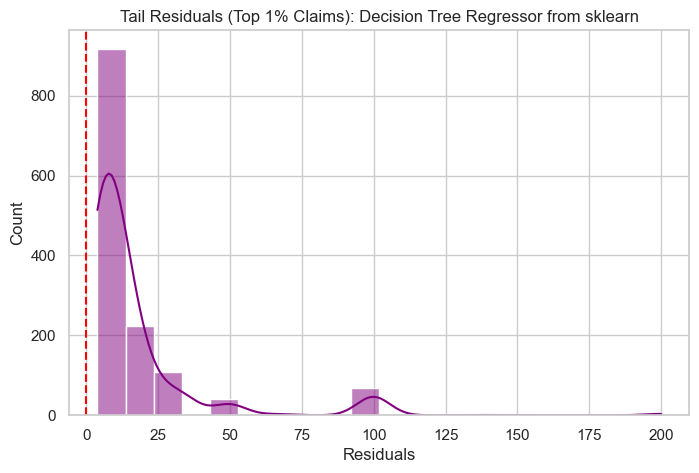

In [26]:
tail_residuals_plot(y_test, y_test_pred, name=name)

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


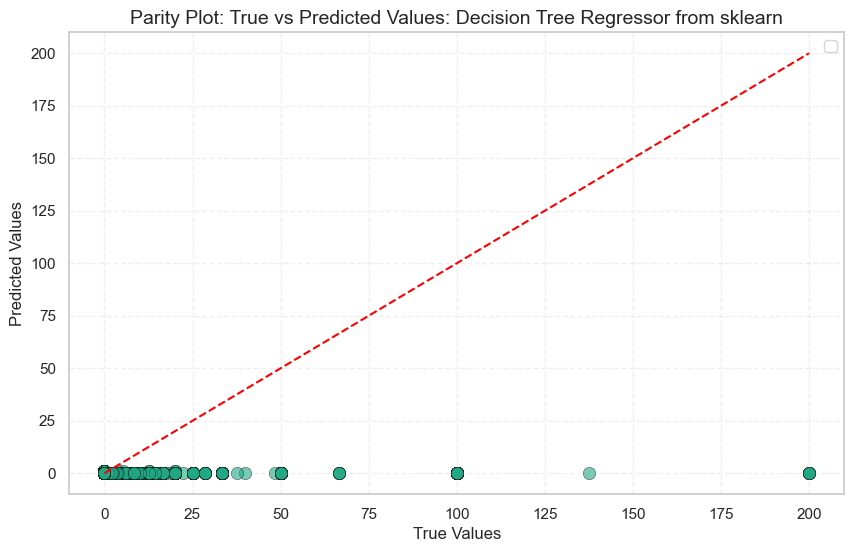

In [27]:
parity_plot(y_true=y_test, y_pred=y_test_pred, name=name)

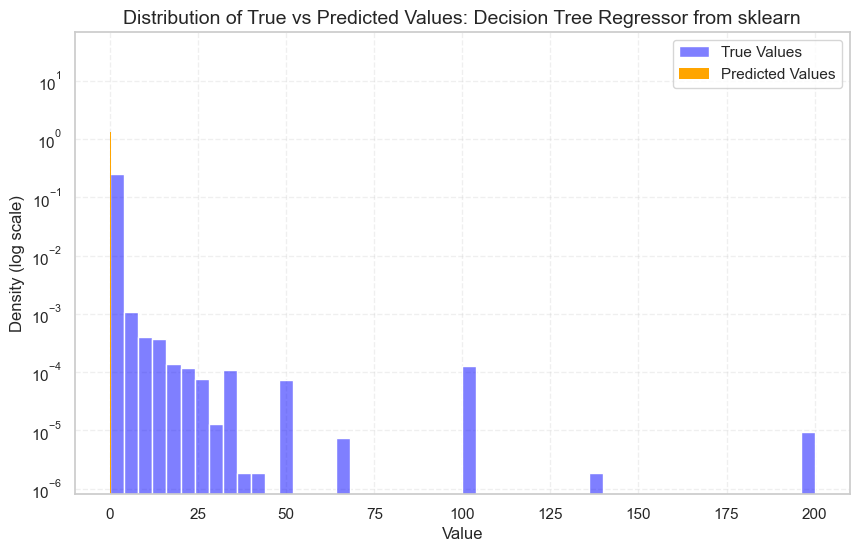

In [28]:
prediction_distribution(y_true=y_test, y_pred=y_test_pred, name=name)

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


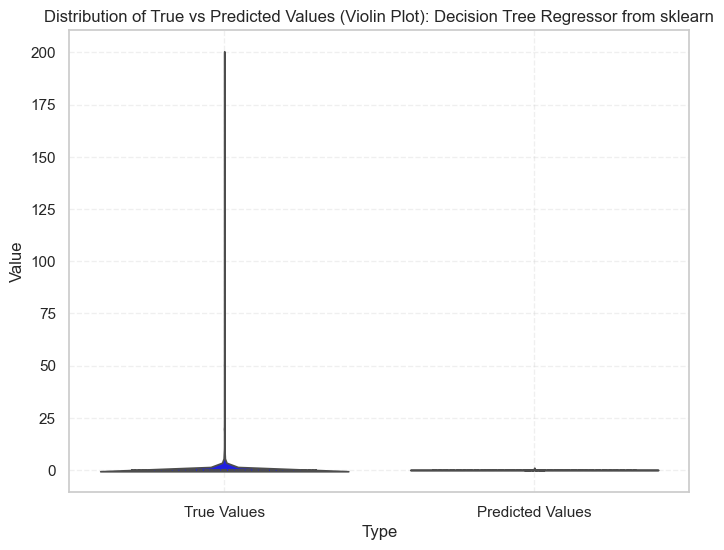

In [29]:
prediction_distribution_violin(y_true=y_test, y_pred=y_test_pred, name=name)

### Saving

And let's save our model as a joblib file.

In [21]:
if not os.path.exists("../models/best_DT_sklearn_model.joblib"):
    joblib.dump(best_model_DT, "../models/best_DT_sklearn_model.joblib")

## Neural Network from pytorch

In [3]:
input_size = X_train.shape[1]  
model = MLP(input_size=input_size)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [9]:
param_grid = {
    'lr': [1e-3, 1e-4],
    'batch_size': [256, 512],
    'epochs': [50, 100],
    'hidden_sizes': [[64,32],[128,64],[256,128]],
}

n_iter = 10

### Training

We have to iterate manually here.

In [ ]:
all_fold_train_rmse = []
all_fold_val_rmse = []
best_val_rmse = float('inf')
best_params = None
best_model_state = None
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for iter_idx in range(n_iter):
    # Sample hyperparameters
    hidden_sizes = random.choice(param_grid['hidden_sizes'])
    lr = random.choice(param_grid['lr'])
    batch_size = random.choice(param_grid['batch_size'])
    epochs = random.choice(param_grid['epochs'])

    fold_val_rmses = []
    fold_train_histories = []
    fold_val_histories = []

    print(f"\n=== Random Search Iteration {iter_idx+1}/{n_iter} ===")
    print(f"Params: hidden={hidden_sizes}, lr={lr}, batch={batch_size}, epochs={epochs}")

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"  Fold {fold_idx+1}/5")

        X_train_now, X_val = X_train[train_idx], X_train[val_idx]
        y_train_now, y_val = y_train_log[train_idx], y_train_log[val_idx]

        model = MLP(input_size=X_train.shape[1], hidden_sizes=hidden_sizes)

        model, train_rmse_list, val_rmse_list = train_model(
            model,
            X_train_now, y_train_now,
            X_val, y_val,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            return_epoch_history=True
        )

        fold_train_histories.append(train_rmse_list)
        fold_val_histories.append(val_rmse_list)

        fold_val_rmses.append(val_rmse_list[-1])
        print(f"    Fold final RMSE: {val_rmse_list[-1]:.4f}")
        
    mean_val_rmse = np.mean(fold_val_rmses)

    results.append({
        'hidden_sizes': hidden_sizes,
        'lr': lr,
        'batch_size': batch_size,
        'epochs': epochs,
        'mean_val_rmse': mean_val_rmse
    })

    print(f"  → Mean CV RMSE: {mean_val_rmse:.4f}")

    if mean_val_rmse < best_val_rmse:
        best_val_rmse = mean_val_rmse
        best_params = results[-1]
        best_model_state = model.state_dict()
        print("  ★ New best model found!")
        
    all_fold_train_rmse.append(fold_train_histories)
    all_fold_val_rmse.append(fold_val_histories)
print("\n=== Search Complete ===")
print("Best RMSE:", best_val_rmse)
print("Best params:", best_params)


=== Random Search Iteration 1/10 ===
Params: hidden=[64, 32], lr=0.0001, batch=512, epochs=100
  Fold 1/5
    Fold RMSE: 0.1018
  Fold 2/5
    Fold RMSE: 0.0979
  Fold 3/5
    Fold RMSE: 0.1000
  Fold 4/5
    Fold RMSE: 0.0993
  Fold 5/5
    Fold RMSE: 0.0993
  → Mean CV RMSE: 0.0997
  ★ New best model found!

=== Random Search Iteration 2/10 ===
Params: hidden=[64, 32], lr=0.0001, batch=512, epochs=50
  Fold 1/5
    Fold RMSE: 0.1018
  Fold 2/5
    Fold RMSE: 0.0977
  Fold 3/5
    Fold RMSE: 0.0999
  Fold 4/5
    Fold RMSE: 0.0992
  Fold 5/5
    Fold RMSE: 0.0994
  → Mean CV RMSE: 0.0996
  ★ New best model found!

=== Random Search Iteration 3/10 ===
Params: hidden=[256, 128], lr=0.001, batch=512, epochs=100
  Fold 1/5
    Fold RMSE: 0.1091
  Fold 2/5
    Fold RMSE: 0.1037
  Fold 3/5
    Fold RMSE: 0.1058
  Fold 4/5
    Fold RMSE: 0.1043
  Fold 5/5
    Fold RMSE: 0.1050
  → Mean CV RMSE: 0.1056

=== Random Search Iteration 4/10 ===
Params: hidden=[64, 32], lr=0.0001, batch=512, epoch

Now we have the best parameters, so let's initialize our final model.

In [11]:
best_params

{'hidden_sizes': [64, 32],
 'lr': 0.0001,
 'batch_size': 256,
 'epochs': 50,
 'mean_val_rmse': np.float64(0.09959443975214924)}

In [12]:
final_model = MLP(
    input_size=X_train.shape[1],
    hidden_sizes=best_params['hidden_sizes'],
)


Let's refit it on the whole training dataset.

In [22]:
final_model, train_rmse, _ = train_model(
    final_model,
    X_train,
    y_train_log,
    X_val=X_train,
    y_val=y_train_log,
    lr=best_params['lr'],
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs']
)


In [26]:
final_model.parameters

<bound method Module.parameters of MLP(
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)>

### Evaluation

Let's evaluate on the training set.

In [37]:
with torch.no_grad():
    y_pred_log = final_model(
        torch.tensor(X_train, dtype=torch.float32)
    ).numpy().flatten()

y_train_pred = logclaim_to_claimrate(y_pred_log)
y_train = logclaim_to_claimrate(y_train_log)


In [48]:
y_train_pred = y_train_pred.clip(0, None)

In [46]:
y_train.min()

np.float64(0.0)

In [49]:
eval_regressor_model(model=None, X=None, y=y_train, y_pred=y_train_pred, log_given=False)

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y and strictly positive y_pred.

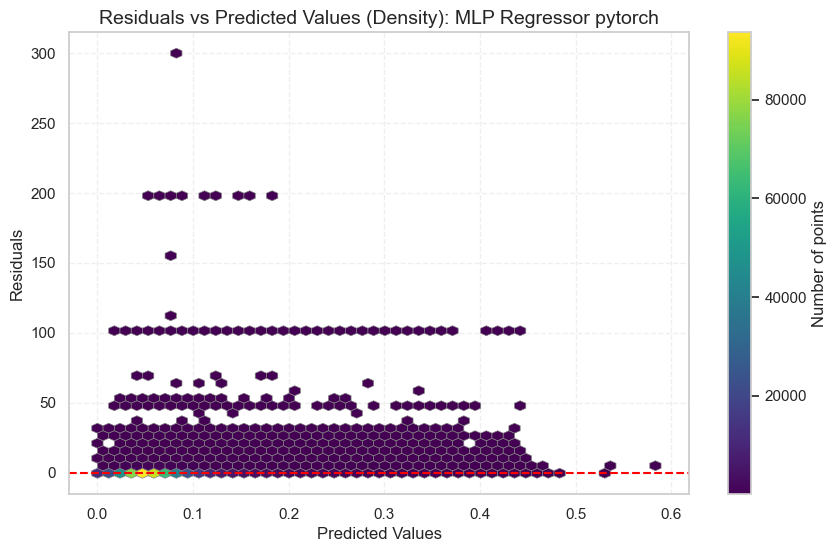

In [51]:
residual_plot(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

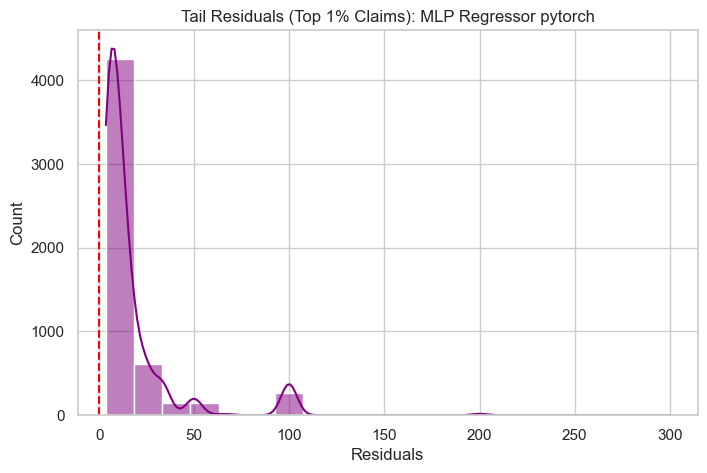

In [55]:
tail_residuals_plot(y_train, y_train_pred, name="MLP Regressor pytorch")

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


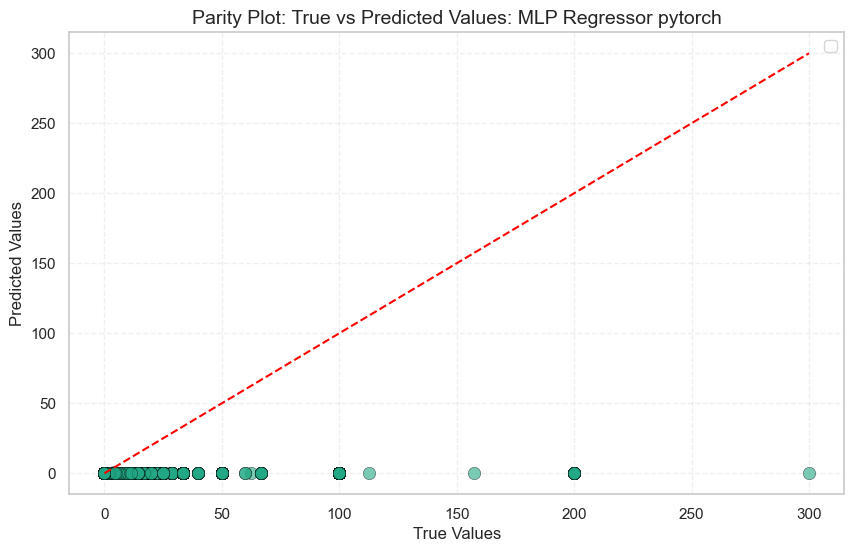

In [52]:
parity_plot(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

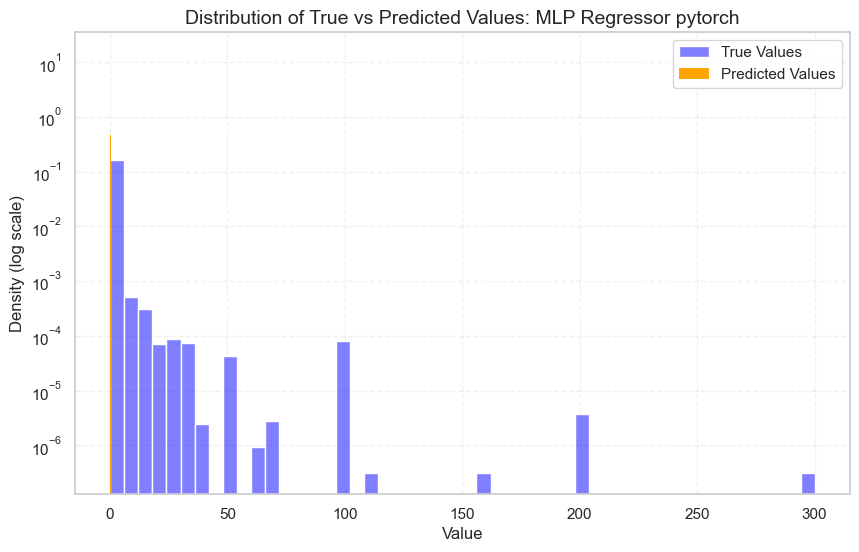

In [53]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


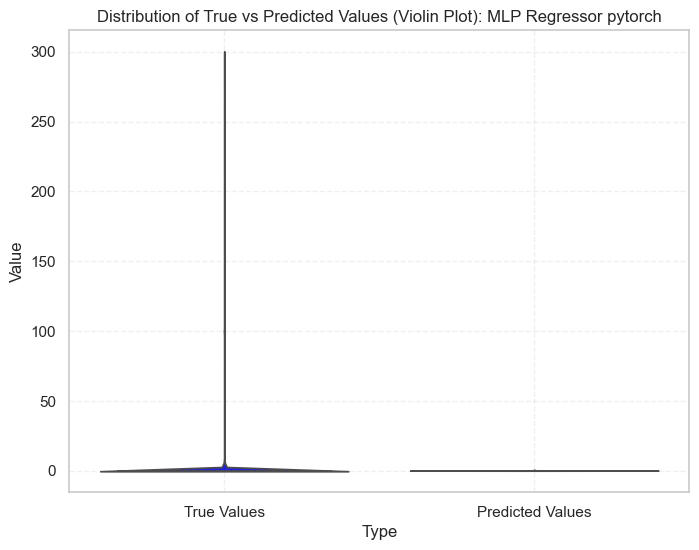

In [54]:
prediction_distribution_violin(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

In [ ]:
plot_epoch_rmse(train_rmse_list, val_rmse_list, name="MLP Regressor pytorch")

InvalidParameterError: The 'estimator' parameter of learning_curve must be an object implementing 'fit'. Got MLP(
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
) instead.

### Evaluation on testing set

In [58]:
with torch.no_grad():
    y_test_pred_log = final_model(
        torch.tensor(X_test, dtype=torch.float32)
    ).numpy().flatten()

y_test_pred = logclaim_to_claimrate(y_test_pred_log)
y_test = logclaim_to_claimrate(y_test_log)


In [59]:
eval_regressor_model(model=None, X=None, y=y_test, y_pred=y_test_pred, log_given=False)

ValueError: Mean Tweedie deviance error with power=1 can only be used on non-negative y and strictly positive y_pred.

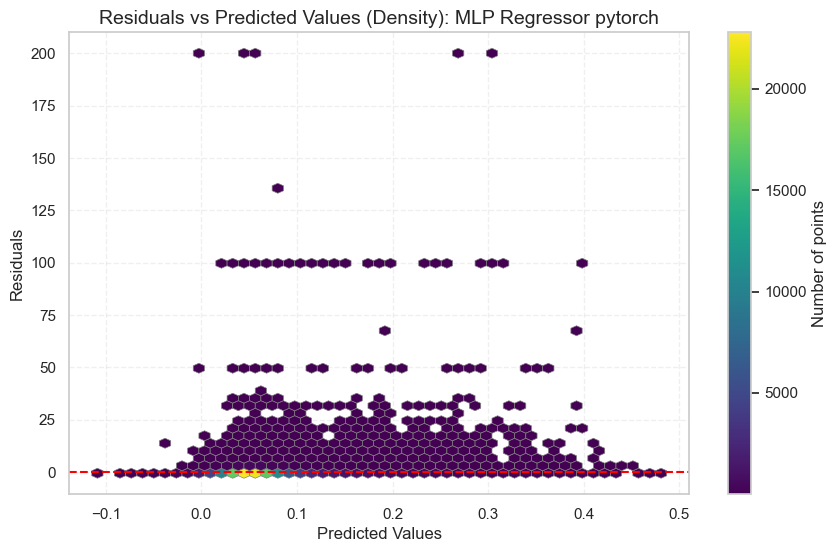

In [61]:
residual_plot(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

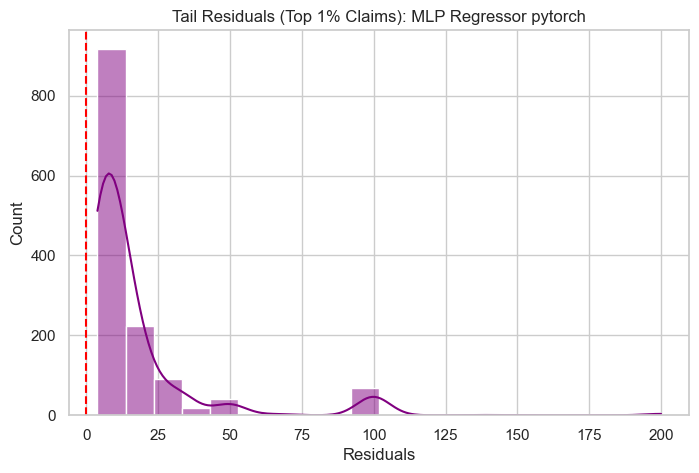

In [62]:
tail_residuals_plot(y_test, y_test_pred, name="MLP Regressor pytorch")

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


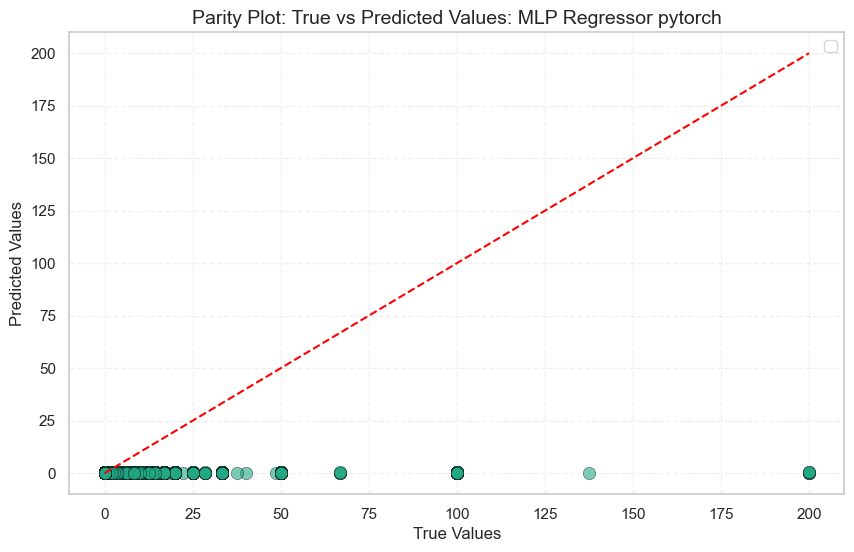

In [60]:
parity_plot(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

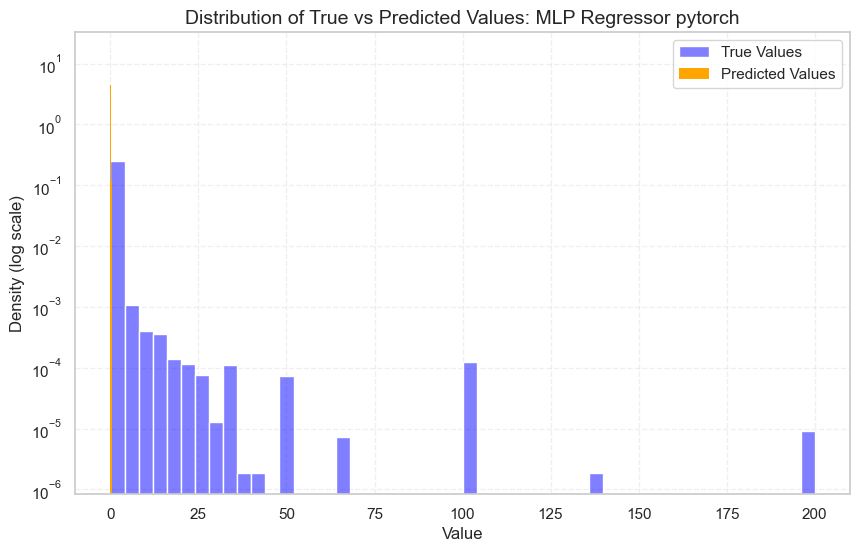

In [63]:
prediction_distribution(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

/Users/anisk/University/3rd semester/Machine Learning/2025-ITU-MachineLearning-Project-Claims-Risk-zrt/src/visualization/model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


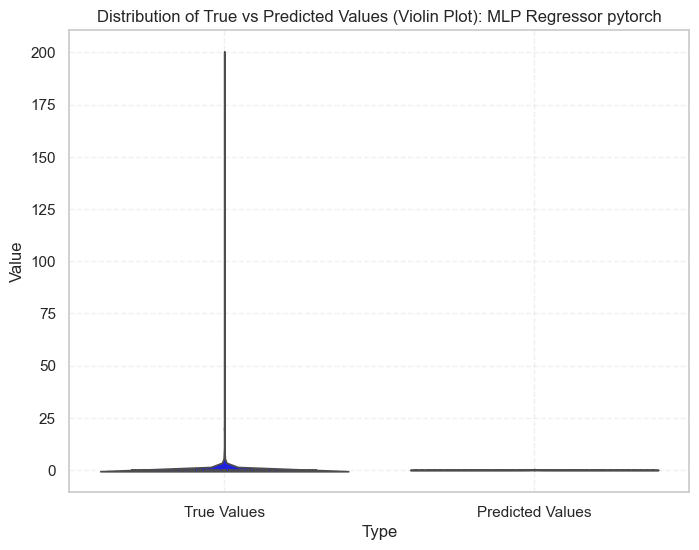

In [64]:
prediction_distribution_violin(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

### Saving

In [28]:
torch.save({
    'model_state_dict': final_model.state_dict(),
    'input_size': X_train.shape[1],
    'hidden_sizes': best_params['hidden_sizes']
}, '../models/best_mlp_pytorch_model.pt')